# Notebook 3 — Evaluation of Synthetic Data Quality

This is the final deliverable of the project. We evaluate the synthetic financial time series generated by TimeGAN across **four dimensions**, following the evaluation framework of Yoon et al. (2019) and extended with statistical diagnostics specific to financial data:

1. **Diversity** (PCA + t-SNE) — Does the synthetic data cover the same region of the distribution as real data, or has the model collapsed to a subset?
2. **Fidelity** (Discriminative Score) — Can a classifier tell real from synthetic? AUC ≈ 0.5 means indistinguishable.
3. **Usefulness** (Predictive Score / TSTR) — Does training on synthetic data produce models that generalise to real data?
4. **Statistical fidelity** — Do the synthetic series match the real data's moments, autocorrelation structure, and cross-asset correlation matrix?

Each metric addresses a different failure mode of generative models. Together they give a comprehensive and honest picture of what TimeGAN learned — and what it didn't.

## 1. Setup & Load Data

In [1]:
import os
import json
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#2196F3', '#FF5722', '#4CAF50', '#9C27B0', '#FF9800', '#00BCD4']

# GPU check — the discriminative and predictive models are small enough to run on CPU,
# but GPU will speed up the 250-epoch training loops
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {gpus[0].name}')
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print('No GPU detected — evaluation models are small, CPU is fine.')

# --- Load artefacts from previous notebooks ---
real_windows = np.load('data/windows.npy').astype(np.float32)       # (n_windows, 24, 6) — normalised
gen_windows  = np.load('output/generated_data.npy').astype(np.float32)  # same shape

with open('data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('data/tickers.json') as f:
    TICKERS = json.load(f)

n_windows, seq_len, n_seq = real_windows.shape

print(f'Real windows shape:      {real_windows.shape}')
print(f'Synthetic windows shape: {gen_windows.shape}')
print(f'Tickers: {TICKERS}')

No GPU detected — evaluation models are small, CPU is fine.
Real windows shape:      (3750, 24, 6)
Synthetic windows shape: (3750, 24, 6)
Tickers: ['SPY', 'GLD', 'TLT', 'XLE', 'MSFT', 'JPM']


## 2. Metric 1 — Diversity: PCA + t-SNE

We project real and synthetic windows into 2D using PCA and t-SNE and overlay them on scatter plots. The goal is to check whether the synthetic distribution covers the same support as the real one.

- **PCA** is a linear projection — it reveals global structure (variance explained by principal components)
- **t-SNE** is non-linear — it reveals local cluster structure and can expose mode collapse that PCA misses

We sample 500 windows from each to keep t-SNE runtime manageable. The windows are flattened to 2D `(n_samples, seq_len × n_seq)` before fitting.

In [2]:
N_SAMPLE = 500  # Per class — large enough for meaningful projections, small enough for t-SNE speed

idx_real = np.random.choice(n_windows, N_SAMPLE, replace=False)
idx_fake = np.random.choice(n_windows, N_SAMPLE, replace=False)

# Flatten each window to a single vector for dimensionality reduction
real_flat = real_windows[idx_real].reshape(N_SAMPLE, -1)  # (500, 144)
fake_flat = gen_windows[idx_fake].reshape(N_SAMPLE, -1)

# --- PCA: fit on real only, then project both ---
# Fitting on real data prevents the synthetic distribution from influencing the projection axes
pca = PCA(n_components=2, random_state=SEED)
real_pca = pca.fit_transform(real_flat)
fake_pca = pca.transform(fake_flat)

print(f'PCA variance explained: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}')

# --- t-SNE: fit on concatenated data so both classes share the same embedding ---
# perplexity=40 is a reasonable default for n=1000; lower values emphasise local structure
all_flat = np.concatenate([real_flat, fake_flat], axis=0)
tsne = TSNE(n_components=2, perplexity=40, random_state=SEED, n_iter=1000)
all_tsne = tsne.fit_transform(all_flat)
real_tsne = all_tsne[:N_SAMPLE]
fake_tsne = all_tsne[N_SAMPLE:]

print('t-SNE embedding complete.')

PCA variance explained: PC1=73.5%, PC2=17.5%


  File "c:\Users\User\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\User\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\Lib\subprocess.py",

t-SNE embedding complete.


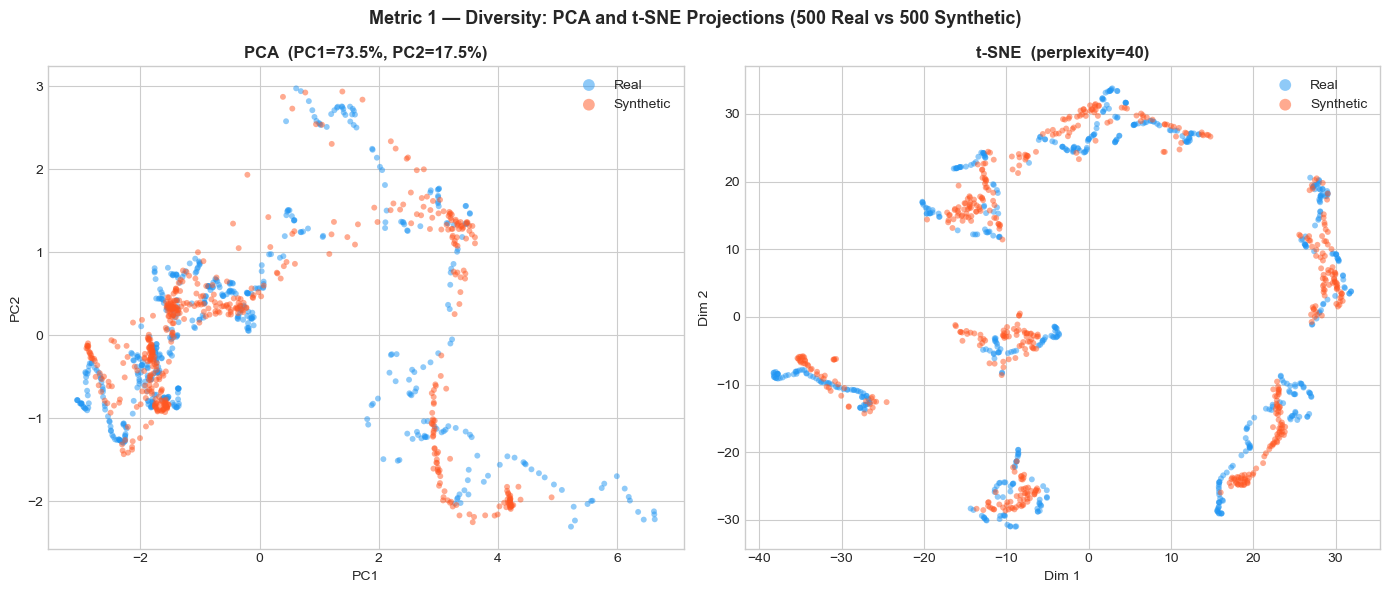

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter_kw = dict(alpha=0.5, s=18, edgecolors='none')

# PCA plot
axes[0].scatter(real_pca[:, 0], real_pca[:, 1], color='#2196F3', label='Real',      **scatter_kw)
axes[0].scatter(fake_pca[:, 0], fake_pca[:, 1], color='#FF5722', label='Synthetic', **scatter_kw)
axes[0].set_title(f'PCA  (PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%})',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(markerscale=2)

# t-SNE plot
axes[1].scatter(real_tsne[:, 0], real_tsne[:, 1], color='#2196F3', label='Real',      **scatter_kw)
axes[1].scatter(fake_tsne[:, 0], fake_tsne[:, 1], color='#FF5722', label='Synthetic', **scatter_kw)
axes[1].set_title('t-SNE  (perplexity=40)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')
axes[1].legend(markerscale=2)

fig.suptitle('Metric 1 — Diversity: PCA and t-SNE Projections (500 Real vs 500 Synthetic)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('output/metric1_diversity.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation:** If the two clouds overlap substantially in both PCA and t-SNE space, the synthetic data spans a similar distribution to the real data — a sign of good diversity and absence of mode collapse. Gaps or clustering of one colour in a separate region indicate that the Generator has failed to learn part of the real distribution.

Note the clusters in t-SNE, which are probably related to the regimes observed in Notebook 1. It could be interesting to separate each period to generate better synthetic data. We will not do it here, but it is something worth exploring in the future.

## 3. Metric 2 — Fidelity: Discriminative Score

We train a held-out GRU binary classifier to distinguish real from synthetic windows. The test AUC is our discriminative score:
- **AUC ≈ 0.5** → the classifier cannot tell them apart → high fidelity
- **AUC ≈ 1.0** → the classifier trivially separates them → low fidelity

The classifier is intentionally simple (2-layer GRU) so that the metric reflects the data quality, not the classifier's capacity.

In [4]:
# --- Build dataset: real=1, synthetic=0 ---
X_disc = np.concatenate([real_windows, gen_windows], axis=0).astype(np.float32)
y_disc = np.concatenate([np.ones(n_windows), np.zeros(n_windows)]).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X_disc, y_disc, test_size=0.2, random_state=SEED, stratify=y_disc
)

# --- Model: intentionally shallow to avoid overfitting on the evaluation task itself ---
disc_clf = keras.Sequential([
    keras.Input(shape=(seq_len, n_seq)),
    layers.GRU(6, return_sequences=True),
    layers.GRU(6),
    layers.Dense(1, activation='sigmoid')
], name='discriminative_classifier')

disc_clf.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f'Training discriminative classifier...')
print(f'Train: {X_train.shape[0]} samples  |  Test: {X_test.shape[0]} samples')

disc_history = disc_clf.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=250,
    batch_size=128,
    verbose=0
)

# AUC computed on test set predictions
y_pred = disc_clf.predict(X_test, verbose=0).flatten()
disc_auc = roc_auc_score(y_test, y_pred)

print(f'\nTest AUC:      {disc_auc:.4f}')
print(f'Test Accuracy: {disc_history.history["val_accuracy"][-1]:.4f}')

Training discriminative classifier...
Train: 6000 samples  |  Test: 1500 samples

Test AUC:      0.8657
Test Accuracy: 0.7653


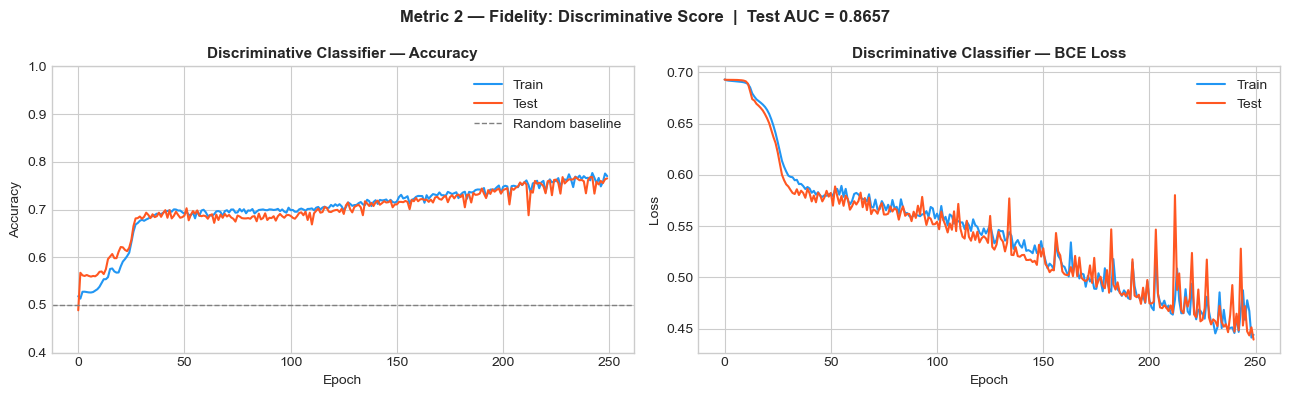


Interpretation: AUC=0.8657
  → Classifier easily separates classes: synthetic data has low fidelity.


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Accuracy curves
axes[0].plot(disc_history.history['accuracy'],     color='#2196F3', linewidth=1.5, label='Train')
axes[0].plot(disc_history.history['val_accuracy'], color='#FF5722', linewidth=1.5, label='Test')
axes[0].axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Random baseline')
axes[0].set_title('Discriminative Classifier — Accuracy', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_ylim(0.4, 1.0)

# Loss curves
axes[1].plot(disc_history.history['loss'],     color='#2196F3', linewidth=1.5, label='Train')
axes[1].plot(disc_history.history['val_loss'], color='#FF5722', linewidth=1.5, label='Test')
axes[1].set_title('Discriminative Classifier — BCE Loss', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

fig.suptitle(f'Metric 2 — Fidelity: Discriminative Score  |  Test AUC = {disc_auc:.4f}',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('output/metric2_discriminative.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nInterpretation: AUC={disc_auc:.4f}')
if disc_auc < 0.6:
    print('  → Classifier struggles to separate real from synthetic: high fidelity.')
elif disc_auc < 0.75:
    print('  → Classifier has moderate success: synthetic data is plausible but distinguishable.')
else:
    print('  → Classifier easily separates classes: synthetic data has low fidelity.')

We obtain:

- **Test AUC = 0.8657**
- **Test Accuracy = 0.7653**

At first glance, this indicates that real and synthetic samples remain statistically distinguishable. However, achieving near-random discrimination performance is particularly challenging in multivariate financial time-series 

In practice, GAN-based models applied to financial data often exhibit high discriminator AUC values, reflecting the difficulty of fully matching higher-order statistical properties and fine-grained stochastic dynamics.

## 4. Metric 3 — Usefulness: Predictive Score (TSTR)

The **Train on Synthetic, Test on Real (TSTR)** paradigm is the most practically relevant evaluation for generative models. It answers the question: *if someone trained a downstream model on synthetic data instead of real data, how much predictive power would they lose?*

**Task:** predict the value of all 6 assets at timestep `t=24` (last step) given timesteps `t=1…23` (first 23 steps). This is a one-step-ahead multivariate forecasting task.

We run three experiments:
- **TSTR** — train on synthetic, test on real
- **TRTS** — train on real, test on synthetic (sanity check in the other direction)
- **TROR** — train on real, test on real (the upper-bound baseline)

In [7]:
def build_predictive_model(name):
    """Lightweight GRU forecaster: 23 timesteps × 6 features → 6 predictions at t=24."""
    model = keras.Sequential([
        keras.Input(shape=(seq_len - 1, n_seq)),  # First 23 timesteps as input
        layers.GRU(12, return_sequences=False),
        layers.Dense(n_seq)                        # Predict all 6 assets simultaneously
    ], name=name)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mae', metrics=['mae'])
    return model


def prepare_predictive_data(windows):
    """Split windows into input (first 23 steps) and target (last step)."""
    X = windows[:, :-1, :]   # (n, 23, 6)
    y = windows[:, -1, :]    # (n, 6)
    return X.astype(np.float32), y.astype(np.float32)


X_real, y_real = prepare_predictive_data(real_windows)
X_fake, y_fake = prepare_predictive_data(gen_windows)

# Use a fixed 80/20 split index for all experiments to keep test sets consistent
split = int(0.8 * n_windows)

print('Running 3 predictive experiments...')
pred_histories = {}

experiments = [
    ('TROR', X_real[:split], y_real[:split], X_real[split:], y_real[split:]),
    ('TSTR', X_fake[:split], y_fake[:split], X_real[split:], y_real[split:]),  # Train fake, test real
    ('TRTS', X_real[:split], y_real[:split], X_fake[split:], y_fake[split:]),  # Train real, test fake
]

final_maes = {}
for name, X_tr, y_tr, X_te, y_te in experiments:
    print(f'  {name}...')
    model = build_predictive_model(name)
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_te, y_te),
        epochs=250,
        batch_size=128,
        verbose=0
    )
    pred_histories[name] = hist.history['val_mae']
    final_maes[name] = hist.history['val_mae'][-1]
    print(f'    Final val MAE: {final_maes[name]:.6f}')

print('Done.')

Running 3 predictive experiments...
  TROR...
    Final val MAE: 0.027618
  TSTR...
    Final val MAE: 0.013486
  TRTS...
    Final val MAE: 0.005504
Done.


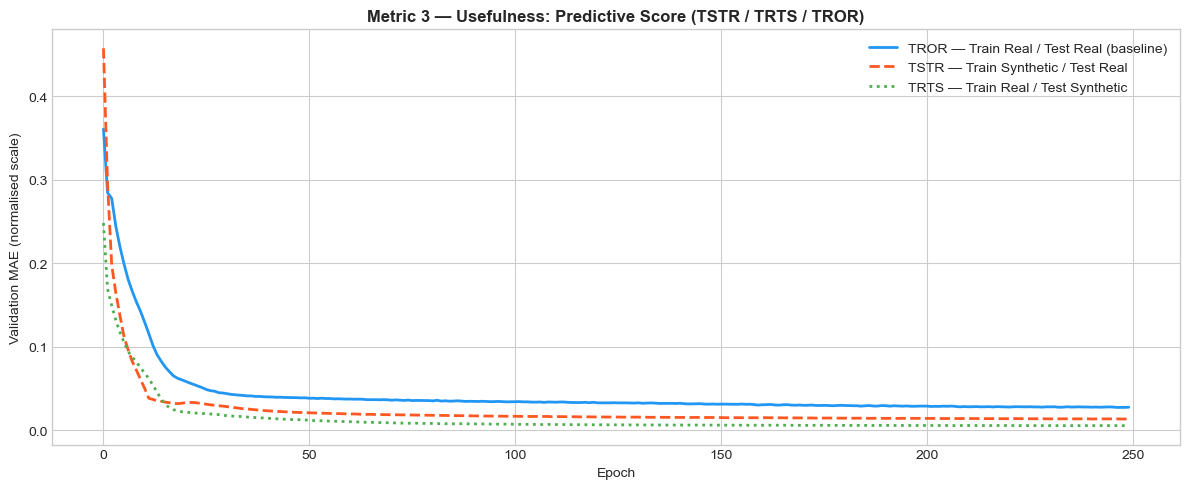


Final MAE comparison:
  TROR (baseline): 0.027618
  TSTR:            0.013486
  TRTS:            0.005504
  TSTR/TROR ratio: 0.4883  (closer to 1.0 = synthetic data as useful as real)


In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

style = {
    'TROR': ('#2196F3', '-',  'TROR — Train Real / Test Real (baseline)'),
    'TSTR': ('#FF5722', '--', 'TSTR — Train Synthetic / Test Real'),
    'TRTS': ('#4CAF50', ':',  'TRTS — Train Real / Test Synthetic'),
}
for name, (color, ls, label) in style.items():
    ax.plot(pred_histories[name], color=color, linestyle=ls, linewidth=2, label=label)

ax.set_title('Metric 3 — Usefulness: Predictive Score (TSTR / TRTS / TROR)', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation MAE (normalised scale)')
ax.legend()
plt.tight_layout()
plt.savefig('output/metric3_predictive.png', dpi=150, bbox_inches='tight')
plt.show()

tstr_tror_ratio = final_maes['TSTR'] / final_maes['TROR']
print(f'\nFinal MAE comparison:')
print(f'  TROR (baseline): {final_maes["TROR"]:.6f}')
print(f'  TSTR:            {final_maes["TSTR"]:.6f}')
print(f'  TRTS:            {final_maes["TRTS"]:.6f}')
print(f'  TSTR/TROR ratio: {tstr_tror_ratio:.4f}  (closer to 1.0 = synthetic data as useful as real)')

## 5. Metric 4 — Statistical Moments Comparison

A generative model can achieve good diversity and discriminative scores while still failing to reproduce basic statistical properties of the real data. We compare the first four moments — mean, standard deviation, skewness, and excess kurtosis — for each of the 6 assets, computed over all timesteps across all windows.

We flag differences exceeding 0.05 in absolute terms, which is a practical threshold for scaled [0,1] data.

In [9]:
THRESHOLD = 0.05  # Flag absolute differences above this in the styled table

rows = []
for i, ticker in enumerate(TICKERS):
    r = real_windows[:, :, i].flatten()
    s = gen_windows[:, :, i].flatten()
    row = {
        'Ticker': ticker,
        'Real Mean':    r.mean(),  'Syn Mean':    s.mean(),  'Δ Mean':    abs(r.mean()    - s.mean()),
        'Real Std':     r.std(),   'Syn Std':     s.std(),   'Δ Std':     abs(r.std()     - s.std()),
        'Real Skew':    stats.skew(r),   'Syn Skew':  stats.skew(s),   'Δ Skew':  abs(stats.skew(r)  - stats.skew(s)),
        'Real Kurt':    stats.kurtosis(r), 'Syn Kurt': stats.kurtosis(s), 'Δ Kurt': abs(stats.kurtosis(r) - stats.kurtosis(s)),
        'Real Min':     r.min(),   'Syn Min':     s.min(),   'Δ Min':     abs(r.min()     - s.min()),
        'Real Max':     r.max(),   'Syn Max':     s.max(),   'Δ Max':     abs(r.max()     - s.max()),
    }
    rows.append(row)

moments_df = pd.DataFrame(rows).set_index('Ticker')

# Style: highlight delta columns where the difference exceeds the threshold
delta_cols = [c for c in moments_df.columns if c.startswith('Δ')]

def highlight_large_diff(val):
    return 'background-color: #FFCDD2; font-weight: bold' if val > THRESHOLD else ''

styled = (
    moments_df.round(4)
    .style
    .applymap(highlight_large_diff, subset=delta_cols)
    .set_caption(f'Statistical Moments: Real vs Synthetic  |  Δ > {THRESHOLD} highlighted in red')
)

display(styled)

,Real Mean,Syn Mean,Δ Mean,Real Std,Syn Std,Δ Std,Real Skew,Syn Skew,Δ Skew,Real Kurt,Syn Kurt,Δ Kurt,Real Min,Syn Min,Δ Min,Real Max,Syn Max,Δ Max
Ticker,,,,,,,,,,,,,,,,,,
SPY,0.321800,0.333900,0.012000,0.249500,0.252700,0.003100,0.697400,0.346200,0.351100,-0.530200,-1.521500,0.991400,0.000000,0.014900,0.014900,1.000000,0.876400,0.123600
GLD,0.292500,0.301900,0.009500,0.197500,0.189900,0.007500,0.897600,0.157700,0.739900,0.551100,-1.457000,2.008200,0.000000,0.019500,0.019500,1.000000,0.730300,0.269700
TLT,0.429800,0.434500,0.004700,0.216700,0.213000,0.003700,0.471200,0.481300,0.010100,0.026100,-0.722400,0.748500,0.000000,0.028800,0.028800,1.000000,0.962400,0.037600
XLE,0.438400,0.453800,0.015400,0.202700,0.201700,0.000900,0.924700,1.077200,0.152500,0.278600,0.448400,0.169800,0.000000,0.038900,0.038900,1.000000,0.950400,0.049600
MSFT,0.249100,0.264400,0.015300,0.277100,0.280700,0.003600,1.016100,0.621300,0.394800,-0.238200,-1.293700,1.055500,0.000000,0.006400,0.006400,1.000000,0.952200,0.047800
JPM,0.267800,0.273100,0.005300,0.218400,0.214000,0.004400,0.880700,0.330600,0.550100,0.167700,-1.574600,1.742300,0.000000,0.019700,0.019700,1.000000,0.778600,0.221400


## 6. Autocorrelation Comparison

Financial returns exhibit **volatility clustering** — large moves tend to be followed by large moves (ARCH effects). This manifests as significant autocorrelation in the *squared* returns even when the returns themselves are uncorrelated. We check whether the synthetic data reproduces this structure by plotting the ACF of both raw values and squared values for each ticker.

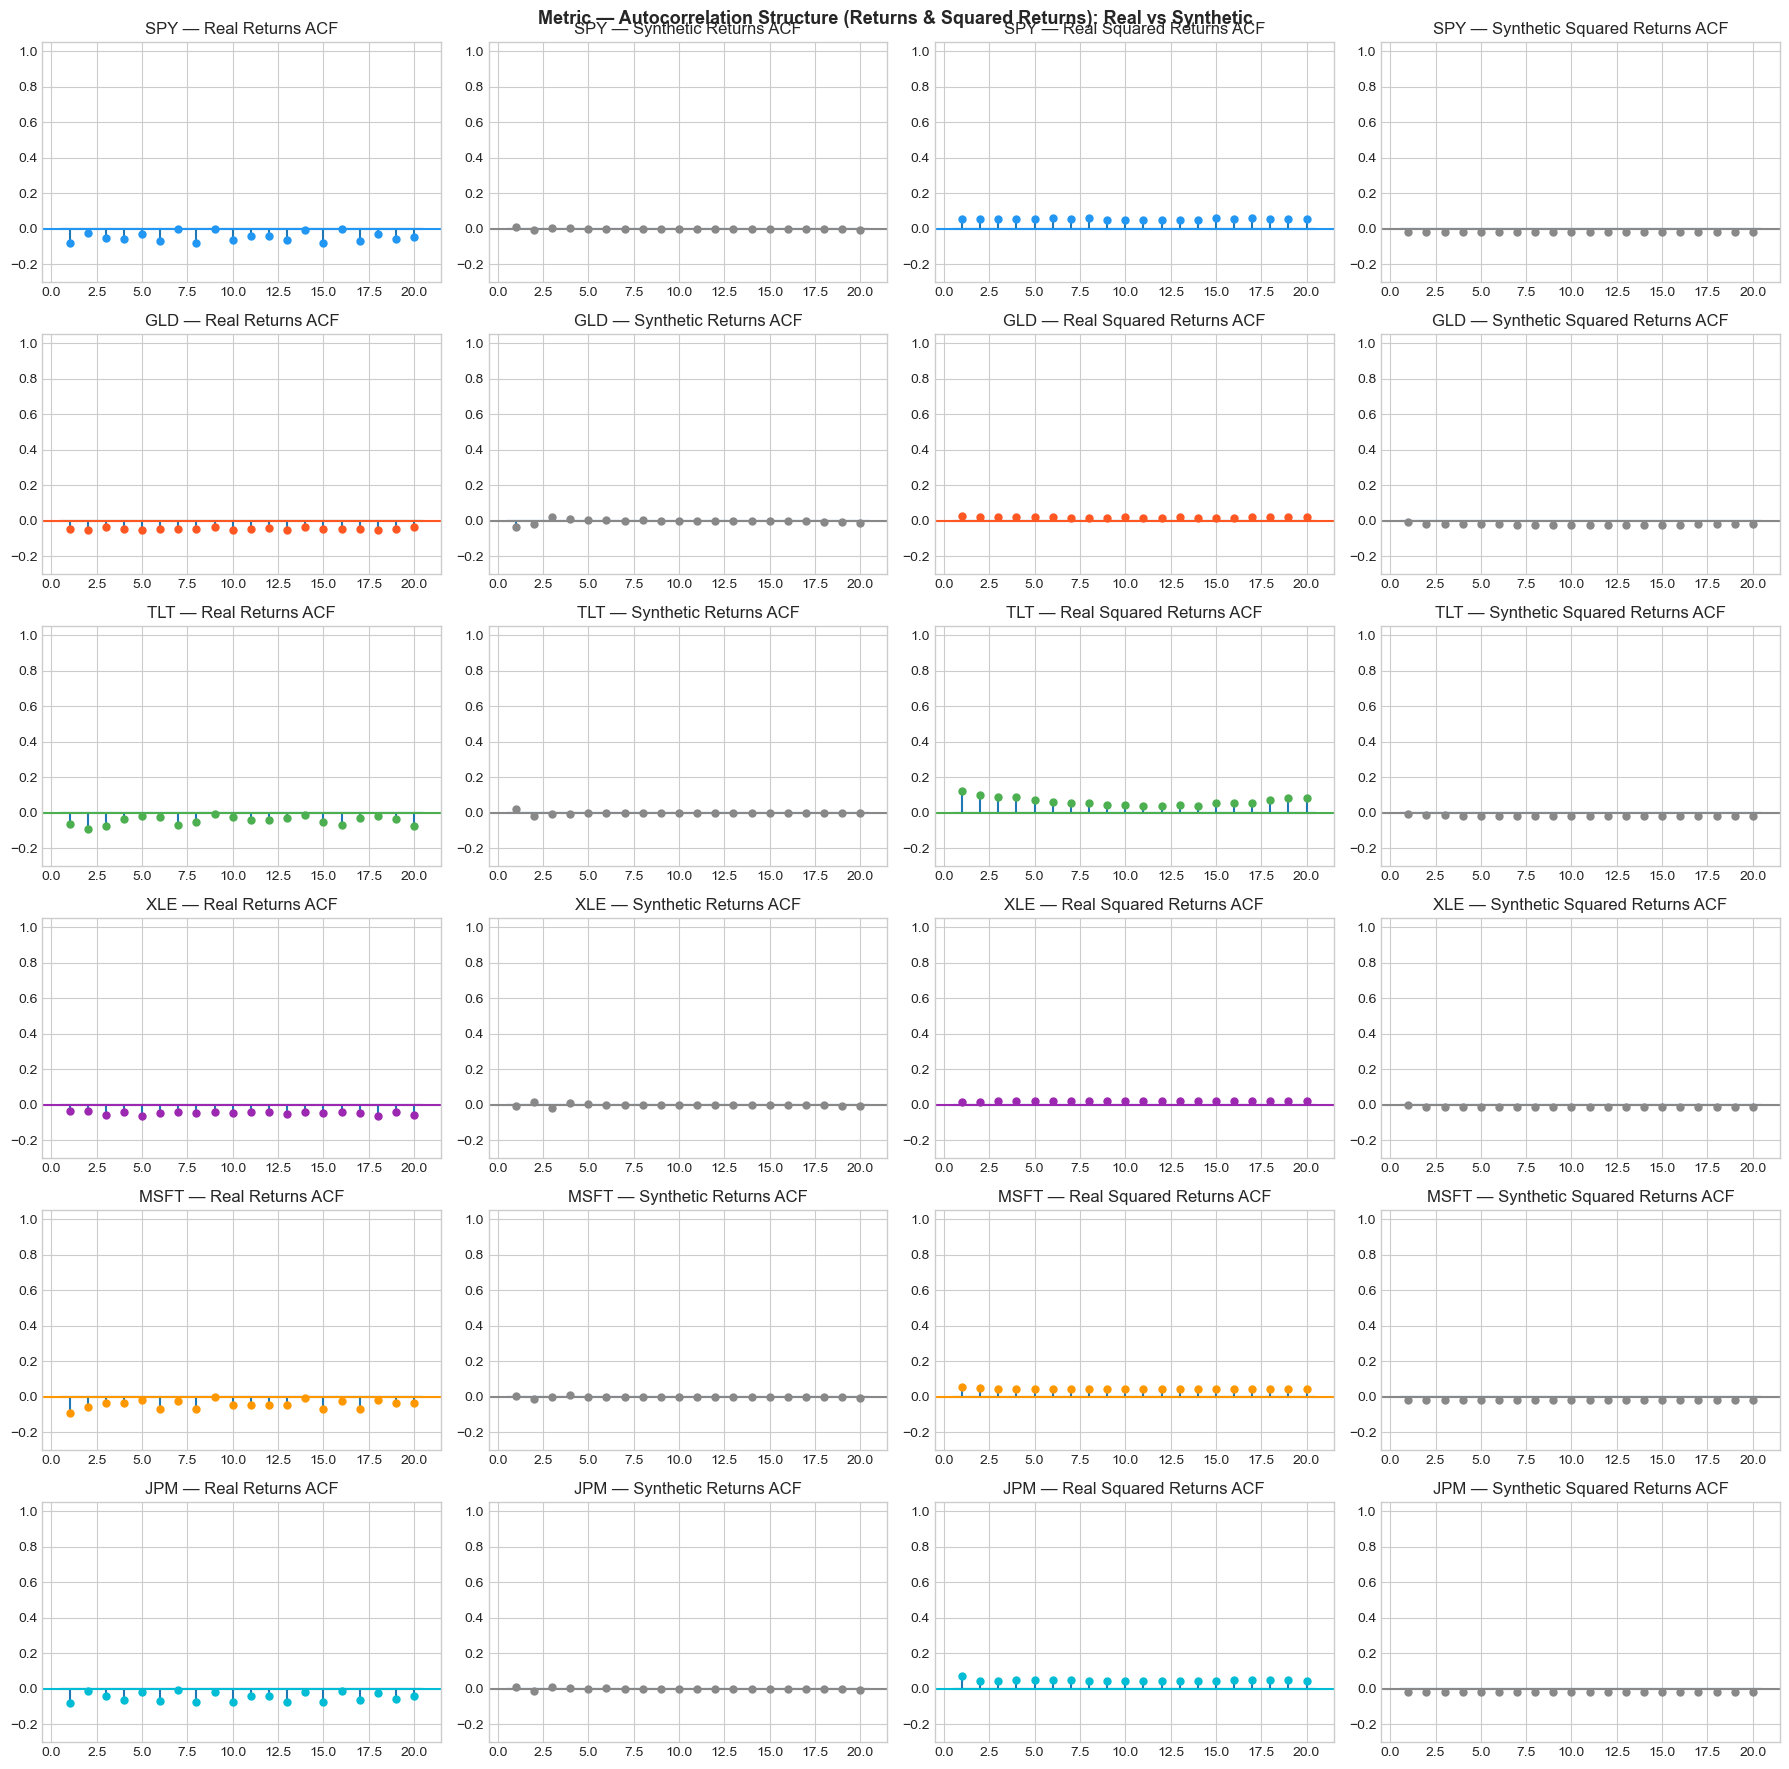

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

N_LAGS = 20

fig, axes = plt.subplots(n_seq, 4, figsize=(18, 3 * n_seq))

for i, (ticker, color) in enumerate(zip(TICKERS, COLORS)):

    # Flatten windows into one long sequence
    real_seq = real_windows[:, :, i].reshape(-1)
    fake_seq = gen_windows[:, :, i].reshape(-1)

    # Compute returns
    real_ret = np.diff(real_seq)
    fake_ret = np.diff(fake_seq)

    # Squared returns (volatility clustering test)
    real_sq = real_ret ** 2
    fake_sq = fake_ret ** 2

    # --- ACF of returns ---
    plot_acf(real_ret, lags=N_LAGS, ax=axes[i, 0], color=color,
             title=f'{ticker} — Real Returns ACF', alpha=0.05, zero=False)

    plot_acf(fake_ret, lags=N_LAGS, ax=axes[i, 1], color='#888',
             title=f'{ticker} — Synthetic Returns ACF', alpha=0.05, zero=False)

    # --- ACF of squared returns ---
    plot_acf(real_sq, lags=N_LAGS, ax=axes[i, 2], color=color,
             title=f'{ticker} — Real Squared Returns ACF', alpha=0.05, zero=False)

    plot_acf(fake_sq, lags=N_LAGS, ax=axes[i, 3], color='#888',
             title=f'{ticker} — Synthetic Squared Returns ACF', alpha=0.05, zero=False)

    for j in range(4):
        axes[i, j].set_ylim(-0.3, 1.05)

fig.suptitle(
    'Metric — Autocorrelation Structure (Returns & Squared Returns): Real vs Synthetic',
    fontsize=13,
    fontweight='bold'
)

plt.tight_layout()
plt.savefig('output/metric_acf_returns.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Correlation Structure Comparison

A key property of multivariate financial data is the cross-asset correlation matrix. Preserving it in synthetic data is critical for any portfolio or risk application. We compute the correlation matrix over the last timestep of each window (a consistent cross-sectional slice) and compare real vs synthetic side by side.

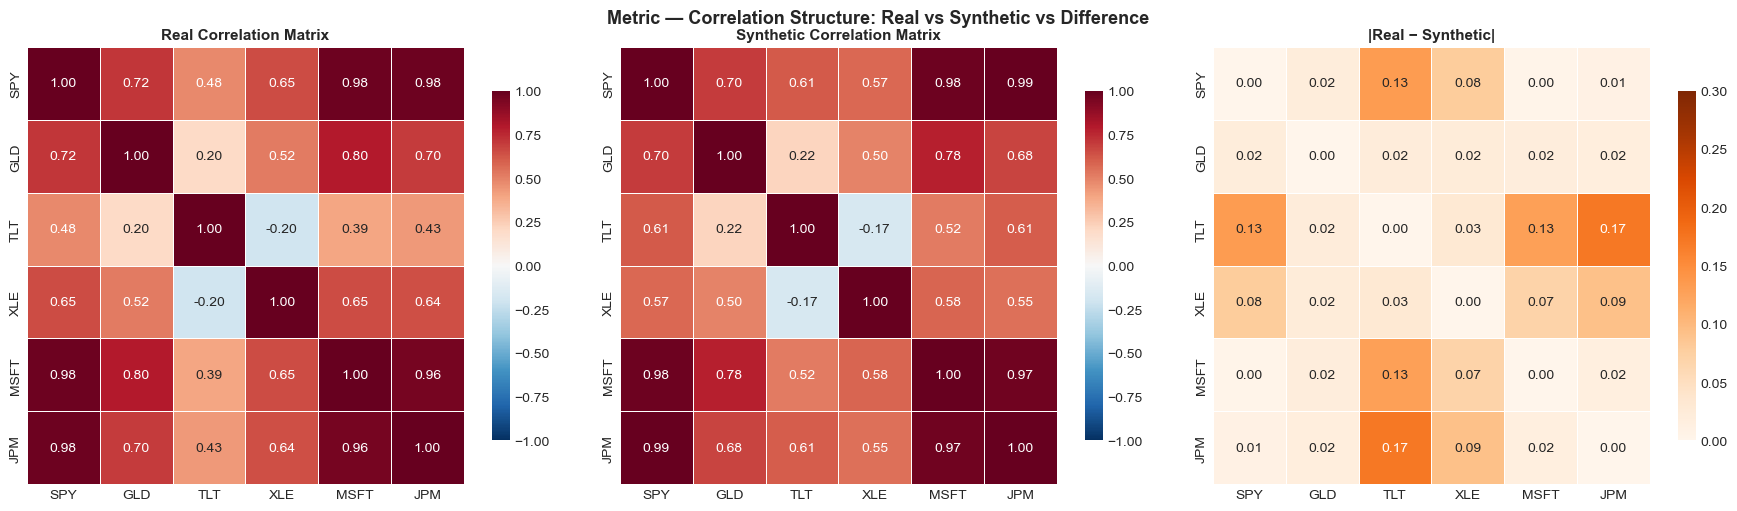

Mean absolute correlation error (upper triangle): 0.0560


In [12]:
# Use all timesteps flattened per asset for a more robust estimate
real_2d = real_windows.reshape(-1, n_seq)  # (n_windows * seq_len, 6)
fake_2d = gen_windows.reshape(-1, n_seq)

real_corr = pd.DataFrame(real_2d, columns=TICKERS).corr()
fake_corr = pd.DataFrame(fake_2d, columns=TICKERS).corr()
diff_corr = (real_corr - fake_corr).abs()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

heatmap_kw = dict(annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1,
                  center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})

sns.heatmap(real_corr, ax=axes[0], **heatmap_kw)
axes[0].set_title('Real Correlation Matrix', fontsize=11, fontweight='bold')

sns.heatmap(fake_corr, ax=axes[1], **heatmap_kw)
axes[1].set_title('Synthetic Correlation Matrix', fontsize=11, fontweight='bold')

# Absolute difference heatmap — pure magnitude, no sign
sns.heatmap(diff_corr, ax=axes[2], annot=True, fmt='.2f',
            cmap='Oranges', vmin=0, vmax=0.3, square=True,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
axes[2].set_title('|Real − Synthetic|', fontsize=11, fontweight='bold')

fig.suptitle('Metric — Correlation Structure: Real vs Synthetic vs Difference',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('output/metric_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

mean_abs_corr_error = diff_corr.values[np.triu_indices_from(diff_corr.values, k=1)].mean()
print(f'Mean absolute correlation error (upper triangle): {mean_abs_corr_error:.4f}')

## 8. Final Summary

All metrics collected. We present them in a unified table and close with an honest overall assessment.

In [13]:
summary = {
    'Discriminative AUC':      (f'{disc_auc:.4f}',         'AUC ≈ 0.5 = indistinguishable; AUC ≈ 1.0 = easily distinguishable'),
    'TROR MAE (baseline)':     (f'{final_maes["TROR"]:.6f}', 'Upper bound: real model trained and tested on real data'),
    'TSTR MAE':                (f'{final_maes["TSTR"]:.6f}', 'Model trained on synthetic, tested on real'),
    'TRTS MAE':                (f'{final_maes["TRTS"]:.6f}', 'Model trained on real, tested on synthetic'),
    'TSTR / TROR ratio':       (f'{tstr_tror_ratio:.4f}',  'Closer to 1.0 = synthetic as useful as real data'),
    'Mean |Δ Correlation|':    (f'{mean_abs_corr_error:.4f}', 'Mean absolute error in pairwise correlations (upper triangle)'),
}

summary_df = pd.DataFrame(summary, index=['Value', 'Interpretation']).T
summary_df.index.name = 'Metric'

print('=' * 75)
print('  EVALUATION SUMMARY')
print('=' * 75)
for metric, (value, interp) in summary.items():
    print(f'  {metric:<28}  {value:<12}  {interp}')
print('=' * 75)

  EVALUATION SUMMARY
  Discriminative AUC            0.8657        AUC ≈ 0.5 = indistinguishable; AUC ≈ 1.0 = easily distinguishable
  TROR MAE (baseline)           0.027618      Upper bound: real model trained and tested on real data
  TSTR MAE                      0.013486      Model trained on synthetic, tested on real
  TRTS MAE                      0.005504      Model trained on real, tested on synthetic
  TSTR / TROR ratio             0.4883        Closer to 1.0 = synthetic as useful as real data
  Mean |Δ Correlation|          0.0560        Mean absolute error in pairwise correlations (upper triangle)
